In [1]:
from pathlib import Path

import pandas as pd
import torchaudio
from fastai.vision.all import *
from fastaudio.all import *

## Data loading

In [2]:
for i, loc in enumerate(Path("../data/audio_segments/").glob("*")):
    print(torchaudio.info(loc))
    if i == 10:
        break

AudioMetaData(sample_rate=48000, num_frames=222408, num_channels=2, bits_per_sample=0, encoding=OPUS)
AudioMetaData(sample_rate=44100, num_frames=4166, num_channels=2, bits_per_sample=0, encoding=AAC)
AudioMetaData(sample_rate=44100, num_frames=584, num_channels=2, bits_per_sample=0, encoding=AAC)
AudioMetaData(sample_rate=48000, num_frames=697608, num_channels=2, bits_per_sample=0, encoding=OPUS)
AudioMetaData(sample_rate=44100, num_frames=10476, num_channels=1, bits_per_sample=0, encoding=AAC)
AudioMetaData(sample_rate=48000, num_frames=11782728, num_channels=1, bits_per_sample=0, encoding=OPUS)
AudioMetaData(sample_rate=48000, num_frames=269448, num_channels=2, bits_per_sample=0, encoding=OPUS)
AudioMetaData(sample_rate=48000, num_frames=479688, num_channels=2, bits_per_sample=0, encoding=OPUS)
AudioMetaData(sample_rate=48000, num_frames=263688, num_channels=2, bits_per_sample=0, encoding=OPUS)
AudioMetaData(sample_rate=48000, num_frames=530568, num_channels=2, bits_per_sample=0, en

It seems that sample rates, channels and encodings vary quite much. Maybe it would have been good to fix these in the splitting phase. The varying lengths will also be a problem, in setting up batches.

Let's at first try to accommodate reading every file, thus setting audio length for minimum length in dataset:

In [3]:
segments = pd.read_parquet("../data/segments_filter.parquet").assign(
    length=lambda df: df["time_end"] - df["time_start"]
)
print(f"Minimum segment length: {segments.length.min():.3f} s")

Minimum segment length: 0.171 s


Whoops. It is so small, that later we will have to cut some segments out of the dataset, or augment it somehow.
At this step, let's take 4 seconds as the lower limit, as it is stated in the dataset documentation.

In [4]:
batch_duration_ms = 4000
quantile_4s = np.mean((segments["length"] < batch_duration_ms / 1000).to_numpy())
print(
    f"Share of segments shorter than {batch_duration_ms} ms: {quantile_4s * 100:.2f} %"
)

Share of segments shorter than 4000 ms: 2.11 %


## Data loading into fast.ai

In [5]:
test = pd.read_parquet("../data/test_filter.parquet")
train = pd.read_parquet("../data/train_filter.parquet")
dev = pd.read_parquet("../data/dev_filter.parquet")

seg_files = pd.read_parquet("../data/etl_segment_summary.parquet")
seg_files = seg_files[~seg_files.path.isna()][["tag", "num", "path"]]


def join_path(data):
    return pd.merge(
        data,
        seg_files,
        left_on=["tag", "seg_num"],
        right_on=["tag", "num"],
        how="inner",
    ).drop(columns=["num"])


test_joined = join_path(test)
train_joined = join_path(train)
dev_joined = join_path(dev)

test_joined.head(3)

,tag,seg_num,Head,Chest,Open,Breathy,Vibrato,Front,Back,song,path
0,tj--7L9MJTo,0,0,0,2,1,2,1,1,Una_furtiva_lagrima,data/audio_segments/tj--7L9MJTo_0.webm
1,zb7tCie8sFE,14,3,3,0,0,0,0,0,Una_furtiva_lagrima,data/audio_segments/zb7tCie8sFE_14.webm
2,1MFnSZ1GPMU,9,3,2,0,0,1,0,0,Una_furtiva_lagrima,data/audio_segments/1MFnSZ1GPMU_9.webm


In [6]:
y_cols = ["Head", "Chest", "Open", "Breathy", "Vibrato", "Front", "Back"]
unique_vals = {
    col_name: tuple(sorted(test[col_name].unique().tolist())) for col_name in y_cols
}
unique_vals

{'Head': (0, 1, 2, 3),
 'Chest': (0, 1, 2, 3),
 'Open': (0, 1, 2, 3),
 'Breathy': (0, 1),
 'Vibrato': (0, 1, 2),
 'Front': (0, 1, 2),
 'Back': (0, 1, 2)}

/home/mikko/.cache/pypoetry/virtualenvs/singing-classifier-1sPnoHl1-py3.10/lib/python3.10/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


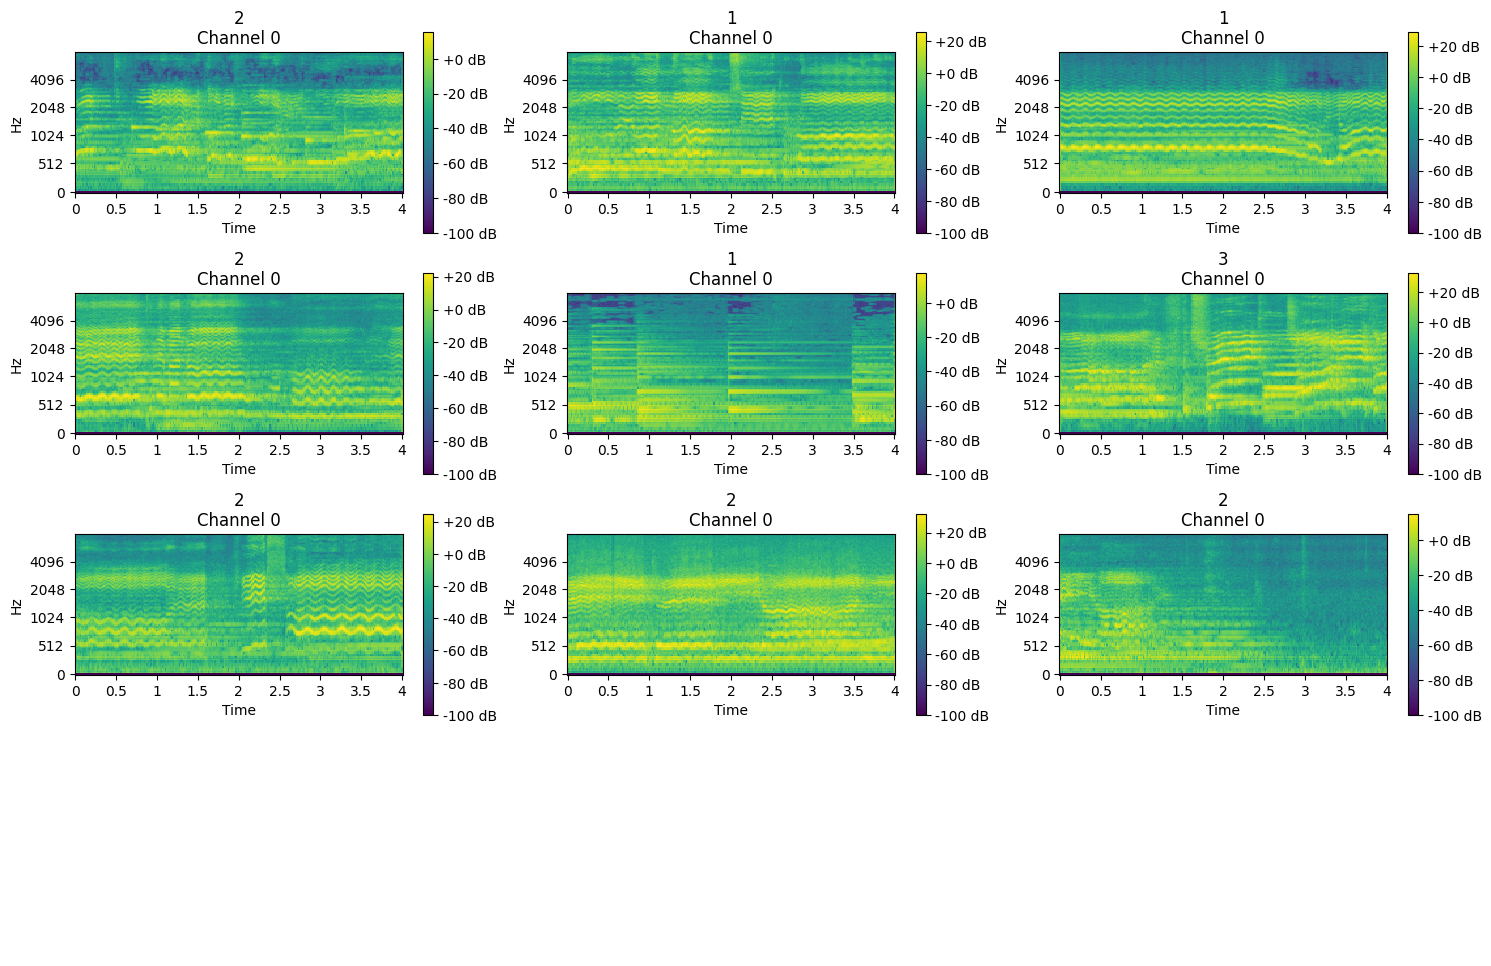

In [7]:
def concat_train_valid(train: pd.DataFrame, valid: pd.DataFrame) -> pd.DataFrame:
    """Concatenate train and valid dataframes, adding column `is_valid`"""
    return pd.concat(
        [train.assign(is_valid=False), valid.assign(is_valid=True)],
        axis=0,
        ignore_index=True,
    )


def splitter(data):
    train = data.index[~data["is_valid"]].tolist()
    valid = data.index[data["is_valid"]].tolist()
    return train, valid


learn_df = concat_train_valid(train_joined, dev_joined)

sample_rate = 16000

cfg = AudioConfig.BasicMelSpectrogram(sample_rate=sample_rate, n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)

dblock = DataBlock(
    blocks=(AudioBlock, CategoryBlock),
    splitter=splitter,
    get_x=ColReader("path", pref="../"),
    get_y=ColReader(y_cols[0]),
    item_tfms=[
        RemoveSilence(),
        ResizeSignal(duration=batch_duration_ms),
        DownmixMono(),
        Resample(sample_rate),
    ],
    batch_tfms=[a2s],
)

dls = dblock.dataloaders(learn_df, bs=12)  # verbose=True
dls.show_batch(nrows=4, ncols=3, figsize=(18, 12))

In [8]:
learn_df.describe()

,seg_num,Head,Chest,Open,Breathy,Vibrato,Front,Back
count,2804.0,2804.0,2804.0,2804.0,2804.0,2804.0,2804.0,2804.0
mean,9.201854,1.799215,1.909772,0.476462,0.135521,0.759272,0.28495,0.289943
std,7.161651,0.746011,0.684201,0.74541,0.34234,0.509107,0.608339,0.539313
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,4.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
50%,8.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0
75%,13.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0
max,44.0,3.0,3.0,3.0,1.0,2.0,2.0,2.0


In [9]:
dls.one_batch()[0].shape

torch.Size([12, 1, 128, 251])

In [58]:
num_classes = len(unique_vals[y_cols[0]])
metrics = [accuracy] + [RocAucBinary() if num_classes == 2 else RocAuc()]

learner = vision_learner(
    dls,
    resnet18,
    n_in=1,  # <- Number of audio channels
    #     loss_func=CrossEntropyLossFlat(),
    metrics=metrics,
)

/home/mikko/.cache/pypoetry/virtualenvs/singing-classifier-1sPnoHl1-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mikko/.cache/pypoetry/virtualenvs/singing-classifier-1sPnoHl1-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.00013182566908653826)

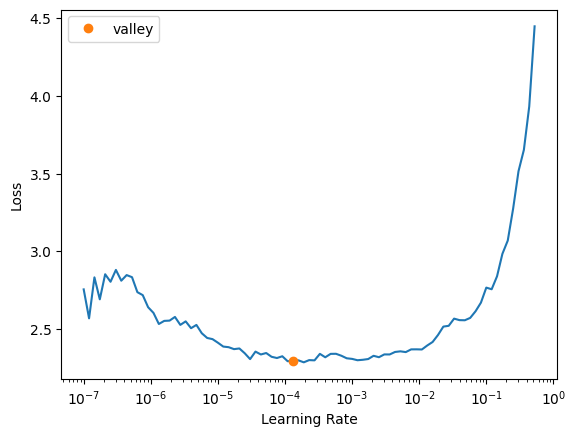

In [59]:
lr_suggested = learner.lr_find(show_plot=True)
lr_suggested

In [12]:
learner.fine_tune(1, lr_suggested.valley)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,2.095713,1.553265,0.472362,0.525690,01:44


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.609009,1.356221,0.488693,0.513671,02:33


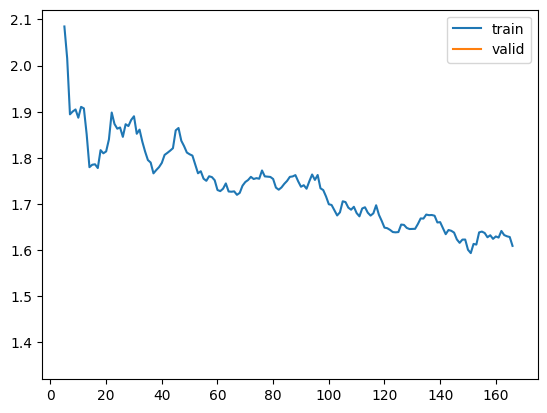

In [13]:
learner.recorder.plot_loss()

In [14]:
learner.summary()

Sequential (Input shape: 12 x 1 x 128 x 251)
Layer (type)         Output Shape         Param #    Trainable 
                     12 x 64 x 64 x 126  
Conv2d                                    3136       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     12 x 64 x 32 x 63   
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                      

In [15]:
learner.validate()

(#3) [1.3353558778762817,0.5012562870979309,0.5185871217964226]

In [16]:
{i.name: float(i.value) for i in learner.metrics}

{'accuracy': 0.5012562870979309, 'roc_auc_score': 0.5185871217964226}

In [17]:
{i.name: float(i.value) for i in learner.recorder.metrics}

{'accuracy': 0.5012562870979309, 'roc_auc_score': 0.5185871217964226}

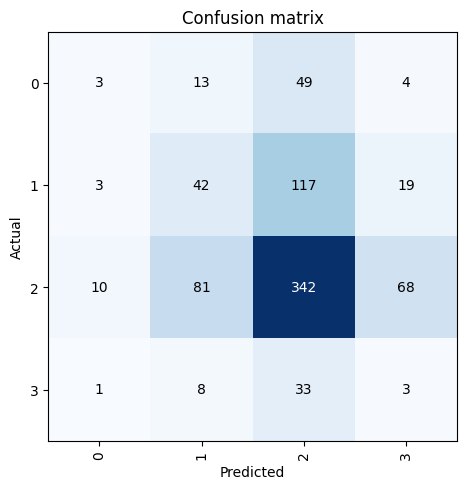

In [18]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

In [19]:
learner.export(f"model.{y_cols[0]}.pkl")

In [20]:
learn_inf = load_learner(f"model.{y_cols[0]}.pkl")

In [21]:
predicted = learn_inf.predict("../" + test_joined["path"][0])
actual = test_joined[y_cols[0]][0]
print(f"{actual=}, {predicted=}")

actual=0, predicted=('2', TensorBase(2), TensorBase([0.1082, 0.0165, 0.7312, 0.1442]))


In [22]:
learn_inf.dls.vocab

[0, 1, 2, 3]

In [23]:
from collections.abc import Sequence


def accuracy_(inp, targ, axis=-1):
    """Fast.ai accuracy metric."""
    pred, targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()


metric_map = {"accuracy": accuracy_}


def evaluate_metrics(
    learn: Learner, paths: Sequence, actual_labels: Sequence
) -> dict[str, float]:
    test_dl = learn.dls.test_dl(paths)
    preds, _ = learn_inf.get_preds(dl=test_dl)
    actual_tensor = TensorBase(actual_labels)

    return {
        met.name: float(metric_map.get(met.name, met)(preds, actual_tensor))
        for met in learn.metrics
    }


evaluate_metrics(
    learn_inf,
    ("../" + test_joined["path"]).tolist(),
    test_joined[y_cols[0]].tolist(),
)

{'accuracy': 0.49066001176834106, 'roc_auc_score': 0.5505222603234528}

In [24]:
evaluate_metrics(
    learn_inf,
    ("../" + dev_joined["path"]).tolist(),
    dev_joined[y_cols[0]].tolist(),
)

{'accuracy': 0.46859297156333923, 'roc_auc_score': 0.5063936670711617}

In [47]:
learner.fine_tune(2, lr_suggested.valley)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.232848,1.360807,0.447236,0.545523,01:53


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.163401,1.419997,0.525126,0.487262,02:26
1,1.069602,1.361322,0.525126,0.501652,02:28


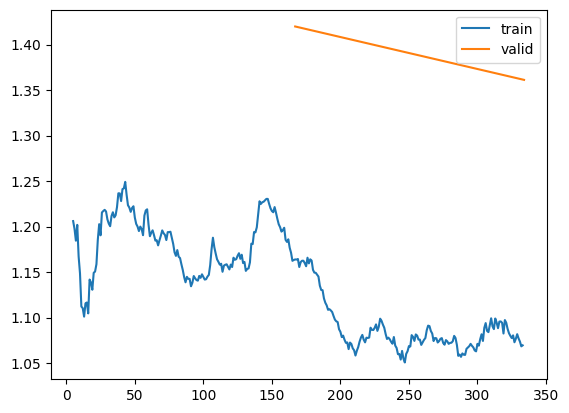

In [48]:
learner.recorder.plot_loss()
plt.savefig("loss_plot.png")

In [49]:
learner.recorder.losses

[TensorBase(1.4842),
 TensorBase(1.3923),
 TensorBase(1.2312),
 TensorBase(1.2525),
 TensorBase(1.2371),
 TensorBase(1.2061),
 TensorBase(1.1976),
 TensorBase(1.1846),
 TensorBase(1.2020),
 TensorBase(1.1673),
 TensorBase(1.1487),
 TensorBase(1.1123),
 TensorBase(1.1104),
 TensorBase(1.1012),
 TensorBase(1.1158),
 TensorBase(1.1167),
 TensorBase(1.1047),
 TensorBase(1.1419),
 TensorBase(1.1388),
 TensorBase(1.1307),
 TensorBase(1.1493),
 TensorBase(1.1507),
 TensorBase(1.1588),
 TensorBase(1.1857),
 TensorBase(1.2027),
 TensorBase(1.1905),
 TensorBase(1.2156),
 TensorBase(1.2172),
 TensorBase(1.2185),
 TensorBase(1.2167),
 TensorBase(1.2080),
 TensorBase(1.2034),
 TensorBase(1.2005),
 TensorBase(1.2116),
 TensorBase(1.2158),
 TensorBase(1.2102),
 TensorBase(1.2126),
 TensorBase(1.2215),
 TensorBase(1.2367),
 TensorBase(1.2366),
 TensorBase(1.2282),
 TensorBase(1.2413),
 TensorBase(1.2421),
 TensorBase(1.2492),
 TensorBase(1.2352),
 TensorBase(1.2236),
 TensorBase(1.2210),
 TensorBase(1

In [50]:
learner.recorder.metric_names

(#6) ['epoch','train_loss','valid_loss','accuracy','roc_auc_score','time']

In [51]:
learner.recorder.values

[(#4) [1.1634010076522827,1.4199968576431274,0.5251256227493286,0.4872622169620492],
 (#4) [1.0696015357971191,1.3613224029541016,0.5251256227493286,0.5016521611107381]]

In [52]:
learner.recorder.iters

[167, 334]

In [57]:
learner.recorder.final_record

(#4) [1.0696015357971191,1.3613224029541016,0.5251256227493286,0.5016521611107381]

In [64]:
??learner.recorder.metrics[1]